In [1]:
import copy, warnings
from oil.tuning.args import argupdated_config
from oil.datasetup.datasets import split_dataset
from oil.tuning.study import train_trial
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from oil.utils.utils import LoaderTo, islice, FixedNumpySeed, cosLr
import biases.datasets as datasets
import biases.dynamicsTrainer as dynamicsTrainer
from biases.datasets import RigidBodyDataset
from biases.dynamicsTrainer import FC,CHFC,CHLC, IntegratedDynamicsTrainer,HNN
from biases.hamiltonian import ChainPendulum
import lie_conv.lieGroups as lieGroups

def makeTrainer(*,network=CHFC,net_cfg={},lr=1e-2,n_train=500,regen=False,
        dataset=RigidBodyDataset,C=5,dt=0.1,dtype=torch.float32,angular=False,
        device=torch.device("cuda"), bs=200,num_epochs=50,trainer_config={}):
    # Create Training set and model
    splits = {"train": n_train, "val": 200, "test": 200}
    dataset = dataset(n_systems=1000, regen=regen, chunk_len=C,body=ChainPendulum(2),
                     dt=dt, integration_time=10,angular_coords=angular)
    with FixedNumpySeed(0):
        datasets = split_dataset(dataset, splits)
    if angular:
        model = HNN(G=dataset.body.body_graph,**net_cfg).to(device=device, dtype=dtype)
    else:
        model = network(G=dataset.body.body_graph,d=2,**net_cfg).to(device=device, dtype=dtype)

    # Create train and Dev(Test) dataloaders and move elems to gpu
    dataloaders = {k: LoaderTo(
                DataLoader(v, batch_size=min(bs, splits[k]), num_workers=0, shuffle=(k == "train")),
                device=device,dtype=dtype) for k, v in datasets.items()}
    dataloaders["Train"] = islice(dataloaders["train"], len(dataloaders["val"]))
    # Initialize optimizer and learning rate schedule
    opt_constr = lambda params: Adam(params, lr=lr)
    lr_sched = cosLr(num_epochs)
    return IntegratedDynamicsTrainer(model,dataloaders,opt_constr,lr_sched,
                                     log_args={"timeFrac": 1 / 4, "minPeriod": 0.0},**trainer_config)


In [6]:
trainer = makeTrainer(dt=.25,C=5,regen=True,lr=3e-3,angular=False)

100
200
300
400
500
600
700
800
900
1000


In [7]:
trainer.train(50)

   Minibatch_Loss  Train_MSE    lr0  nfe  test_MSE   val_MSE
0        0.062544   0.067208  0.003  0.0  0.063112  0.062849
   Minibatch_Loss  Train_MSE       lr0    nfe  test_MSE   val_MSE
4        0.016228   0.015504  0.002999  138.5  0.017218  0.013383
   Minibatch_Loss  Train_MSE       lr0      nfe  test_MSE   val_MSE
8        0.006837   0.006403  0.002996  141.125  0.005762  0.006289
    Minibatch_Loss  Train_MSE      lr0    nfe  test_MSE   val_MSE
12        0.004194    0.00426  0.00299  143.5  0.003333  0.003885
    Minibatch_Loss  Train_MSE       lr0      nfe  test_MSE   val_MSE
16        0.002775   0.002884  0.002982  146.375  0.002735  0.002943
    Minibatch_Loss  Train_MSE      lr0     nfe  test_MSE   val_MSE
20        0.001788   0.001778  0.00297  145.85  0.001499  0.001982
    Minibatch_Loss  Train_MSE       lr0    nfe  test_MSE   val_MSE
24        0.001986    0.00197  0.002957  146.5  0.001682  0.001839
    Minibatch_Loss  Train_MSE      lr0         nfe  test_MSE   val_MSE
2

KeyboardInterrupt: 

In [23]:
from biases.hamiltonian import ChainPendulum, Animation2d, MLE,MLE2
from IPython.display import HTML
import matplotlib.pyplot as plt

In [71]:
P = ChainPendulum(3)
z0s = P.sample_initial_conditions(1).double()


In [45]:
bs = z0.shape[0]
xp = torch.stack([z0s[:,0],P.M@z0s[:,1]],dim=1).reshape(bs,-1)
ts = torch.linspace(0,1000,100).double()
es = MLE2(xp,P.dynamics(wgrad=True),ts,rtol=1e-4)
plt.plot(es[1:,0,-1]/ts[1:])

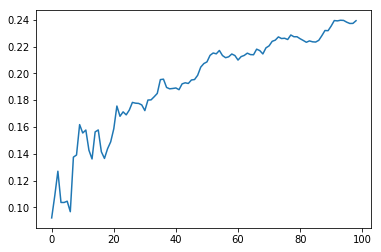

In [96]:
ts = torch.linspace(0,10,500).double()
zt = P.integrate(z0s,ts,tol=1e-6).cuda()
zt_p = P.integrate((z0s+1e-5*torch.randn_like(z0s)),ts,tol=1e-6).cuda()
z0 = z0s.cuda()

In [97]:
with torch.no_grad():
    trainer.model.double()#.float()#double()
    z_hat_t = trainer.model.integrate(z0,ts)

In [98]:
xt = zt[0,:,0,:].permute(1,2,0).cpu()
xt_hat = z_hat_t[0,:,0,:].permute(1,2,0).cpu()
xt_p = zt_p[0,:,0,:].permute(1,2,0).cpu()

In [99]:
err = ((xt-xt_hat)**2).sum(1).sum(0).sqrt()/((xt+xt_hat)**2).sum(1).sum(0).sqrt()
err2 = ((xt-xt_p)**2).sum(1).sum(0).sqrt()/((xt+xt_p)**2).sum(1).sum(0).sqrt()

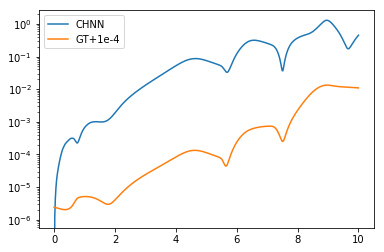

In [100]:
plt.plot(ts,err)
plt.plot(ts,err2)
plt.yscale('log')
plt.legend(['CHNN','GT+1e-4'])

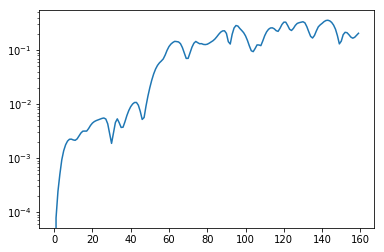

In [42]:
plt.plot(err)
plt.yscale('log')

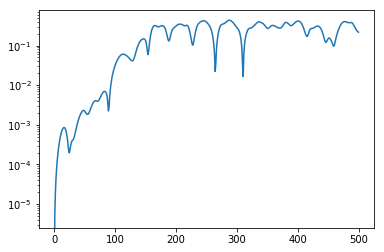

In [39]:
plt.plot(err)
plt.yscale('log')

In [31]:
P.Minv

tensor([[1., 0., -0.],
        [0., 1., -0.],
        [0., 0., 1.]])

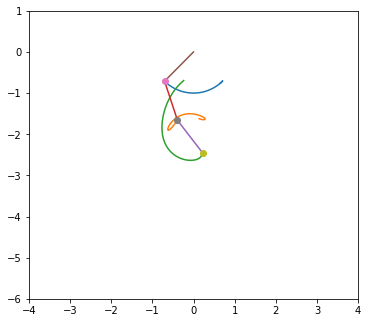

In [66]:
HTML(Animation2d(xt.float(),P,box_lim=(-4,4,-6,1)).animate().to_html5_video())

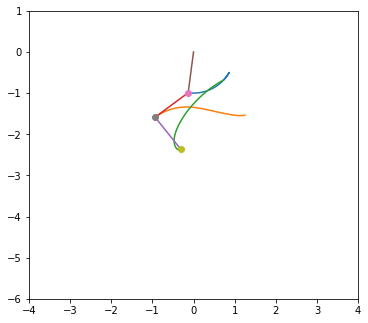

In [67]:
HTML(Animation2d(xt_hat.float(),P,box_lim=(-4,4,-6,1)).animate().to_html5_video())